# Importing Libraries

In [1]:
import os
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from dataclasses import dataclass

# pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

# Hyperparameters

In [2]:
@dataclass
class CONFIG:
    debug: bool = False
    
    # Model
    vocab_size: int = 65
    ## Bigram
    d_embed_bigram: int = 64
    ## Transformer
    model_size: str = 'small'  # 'small' or 'large'
    ### Small
    if model_size == 'small':
        context_size: int = 8
        n_layers: int = 2
        n_heads: int = 4
        d_embed: int = 64
        d_head: int = d_embed // n_heads
        d_ff: int = d_embed * 4
        dropout: float = 0.1
    ### Large
    elif model_size == 'large':
        context_size: int = 128
        n_layers: int = 6
        n_heads: int = 4
        d_embed: int = 64
        d_head: int = d_embed // n_heads
        d_ff: int = d_embed * 4
        dropout: float = 0.2

    flash_attention: bool = False
    
    # Dataset
    dtype: torch.dtype = torch.long
    validation_size: float = 0.2
    
    # Device
    device: torch.device = None
    
    # Training
    epochs: int = 10
    batch_size: int = 1024
    learning_rate: float = 2e-5
    
    # Generation
    max_len: int = 1000
    
    # Seed
    seed: int = 101

# Reproducibility

In [3]:
def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    print(f"Seed: {seed}")
    
set_seed(CONFIG.seed)

Seed: 101


# Device

In [4]:
def configure_device():
    if torch.cuda.is_available():
        device = torch.device("cuda")
        num_gpu = torch.cuda.device_count()
        print("> Running on GPU", end=' | ')
        print("Num of GPUs: ", num_gpu)
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
        print("> Running on MPS")
    else:
        device = torch.device("cpu")
        print("> Running on CPU")
    return device

CONFIG.device = configure_device()

> Running on MPS


# Debug

In [5]:
if CONFIG.debug:
    CONFIG.epochs = 1
    CONFIG.max_len = 100

# Dataset

In [6]:
# dataset path
dataset_path = 'data/'
# shakespeare dataset
shakespeare_dataset = dataset_path + 'shakespeare.txt'

In [7]:
with open(shakespeare_dataset, 'r', encoding='utf-8') as f:
    shakespeare_text = f.read()

In [8]:
print(shakespeare_text[:1000])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



In [9]:
print(f'Total number of characters in the text: {len(shakespeare_text)}')

Total number of characters in the text: 1115394


In [10]:
chars = sorted(list(set(shakespeare_text)))
vocab_size = len(chars)
CONFIG.vocab_size = vocab_size
print(f'Unique characters: {chars}')
print(f'Total number of unique characters: {vocab_size}')

Unique characters: ['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Total number of unique characters: 65


# Tokenization (Character Level)

In [11]:
char_to_int = {c: i for i, c in enumerate(chars)}
encode = lambda s: [char_to_int[c] for c in s]
int_to_char = {i: c for i, c in enumerate(chars)}
decode = lambda l: "".join([int_to_char[i] for i in l])

In [12]:
print(f'Character to integer mapping: {char_to_int}')
print(f'Integer to character mapping: {int_to_char}')

Character to integer mapping: {'\n': 0, ' ': 1, '!': 2, '$': 3, '&': 4, "'": 5, ',': 6, '-': 7, '.': 8, '3': 9, ':': 10, ';': 11, '?': 12, 'A': 13, 'B': 14, 'C': 15, 'D': 16, 'E': 17, 'F': 18, 'G': 19, 'H': 20, 'I': 21, 'J': 22, 'K': 23, 'L': 24, 'M': 25, 'N': 26, 'O': 27, 'P': 28, 'Q': 29, 'R': 30, 'S': 31, 'T': 32, 'U': 33, 'V': 34, 'W': 35, 'X': 36, 'Y': 37, 'Z': 38, 'a': 39, 'b': 40, 'c': 41, 'd': 42, 'e': 43, 'f': 44, 'g': 45, 'h': 46, 'i': 47, 'j': 48, 'k': 49, 'l': 50, 'm': 51, 'n': 52, 'o': 53, 'p': 54, 'q': 55, 'r': 56, 's': 57, 't': 58, 'u': 59, 'v': 60, 'w': 61, 'x': 62, 'y': 63, 'z': 64}
Integer to character mapping: {0: '\n', 1: ' ', 2: '!', 3: '$', 4: '&', 5: "'", 6: ',', 7: '-', 8: '.', 9: '3', 10: ':', 11: ';', 12: '?', 13: 'A', 14: 'B', 15: 'C', 16: 'D', 17: 'E', 18: 'F', 19: 'G', 20: 'H', 21: 'I', 22: 'J', 23: 'K', 24: 'L', 25: 'M', 26: 'N', 27: 'O', 28: 'P', 29: 'Q', 30: 'R', 31: 'S', 32: 'T', 33: 'U', 34: 'V', 35: 'W', 36: 'X', 37: 'Y', 38: 'Z', 39: 'a', 40: 'b', 41

In [13]:
sample_text = 'Hello, World!'
sample_text_int = encode(sample_text)
print(f'Text: {sample_text}')
print(f'Encoded text: {sample_text_int}')
print(f'Decoded text: {decode(sample_text_int)}')

Text: Hello, World!
Encoded text: [20, 43, 50, 50, 53, 6, 1, 35, 53, 56, 50, 42, 2]
Decoded text: Hello, World!


In [14]:
shakespeare_tokens = torch.tensor(encode(shakespeare_text), dtype=CONFIG.dtype)

In [15]:
print(f'Sample tokens: {shakespeare_tokens[:100]}')
print(f'Total number of tokens: {len(shakespeare_tokens)}')
print(f'Total number of unique tokens: {len(torch.unique(shakespeare_tokens))}')
print(f'dtype: {shakespeare_tokens.dtype}')

Sample tokens: tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59])
Total number of tokens: 1115394
Total number of unique tokens: 65
dtype: torch.int64


# Preprocessing

In [16]:
# Train Validation Split
train_size = int(len(shakespeare_tokens) * (1 - CONFIG.validation_size))
train_tokens = shakespeare_tokens[:train_size]
validation_tokens = shakespeare_tokens[train_size:]
print(f'Total number of tokens in the training set: {len(train_tokens)}')
print(f'Total number of tokens in the validation set: {len(validation_tokens)}')

Total number of tokens in the training set: 892315
Total number of tokens in the validation set: 223079


In [17]:
class ShakespeareDataset(Dataset):
    def __init__(self, tokens, context_size):
        self.tokens = tokens
        self.context_size = context_size
        
    def __len__(self):
        return len(self.tokens) - self.context_size
    
    def __getitem__(self, idx):
        return self.tokens[idx:idx+self.context_size], self.tokens[idx+1:idx+self.context_size+1]

train_dataset = ShakespeareDataset(train_tokens, CONFIG.context_size)
validation_dataset = ShakespeareDataset(validation_tokens, CONFIG.context_size)
train_loader = DataLoader(train_dataset, batch_size=CONFIG.batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=CONFIG.batch_size, shuffle=False)

In [18]:
sample_x, sample_y = next(iter(train_loader))
sample_x, sample_y = sample_x.to(CONFIG.device), sample_y.to(CONFIG.device)
print(sample_x.shape, sample_y.shape)
print(sample_x[0])
print(sample_y[0])

torch.Size([1024, 8]) torch.Size([1024, 8])
tensor([27, 25, 17, 27, 10,  0, 25, 43], device='mps:0')
tensor([25, 17, 27, 10,  0, 25, 43, 39], device='mps:0')


# Model

## Bigram

In [19]:
class Bigram(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.vocab_size = config.vocab_size
        self.d_embed = config.d_embed_bigram
        self.max_len = config.max_len
        
        self.embedding = nn.Embedding(self.vocab_size, self.d_embed)
        self.linear = nn.Linear(self.d_embed, self.vocab_size)
        
    def forward(self, x):  # [batch_size, context_size]
        x = self.embedding(x)  # [batch_size, context_size, d_embed]
        x = self.linear(x)  # [batch_size, context_size, vocab_size]
        return x
    
    def loss(self, x, y):  # y: [batch_size, context_size]
        y = y.view(-1)  # [batch_size * context_size]
        y_pred = self.forward(x)  # [batch_size, context_size, vocab_size]
        y_pred = y_pred.view(-1, self.vocab_size)  # [batch_size * context_size, vocab_size]
        return F.cross_entropy(y_pred, y)
    
    @torch.no_grad()
    def generate(self, x, max_len = None, decode_fn=None):
        self.eval()
        if max_len is None:
            max_len = self.max_len
        for _ in range(max_len):  # x: [batch_size, context]
            output = self.forward(x)  # [batch_size, context_size, vocab_size]
            next_token = torch.argmax(output[:, -1, :], dim=-1).unsqueeze(-1)  # [batch_size, 1]
            x = torch.cat((x, next_token), dim=-1)  # [batch_size, context]
            
            # Decode token
            if decode_fn is not None:
                decoded_token = decode_fn([next_token[0].item()])
                print(decoded_token, end='', flush=True)

In [20]:
bigram = Bigram(CONFIG).to(CONFIG.device)
print(bigram)

Bigram(
  (embedding): Embedding(65, 64)
  (linear): Linear(in_features=64, out_features=65, bias=True)
)


In [21]:
loss = bigram.loss(sample_x, sample_y)
print(loss)

bigram.generate(sample_x, max_len=100, decode_fn=decode)

tensor(4.3181, device='mps:0', grad_fn=<NllLossBackward0>)
DoPRlQzy&d3RlQzy&d3RlQzy&d3RlQzy&d3RlQzy&d3RlQzy&d3RlQzy&d3RlQzy&d3RlQzy&d3RlQzy&d3RlQzy&d3RlQzy&d3R

## Transformer

In [22]:
class CausalSelfAttention(nn.Module):
    def __init__(self, d_embed: int, n_heads: int, d_head: int):
        super().__init__()
        self.d_embed = d_embed
        self.n_heads = n_heads
        self.d_head = d_head
        
        self.query = nn.Linear(self.d_embed, self.n_heads * self.d_head, bias=False)
        self.key = nn.Linear(self.d_embed, self.n_heads * self.d_head, bias=False)
        self.value = nn.Linear(self.d_embed, self.n_heads * self.d_head, bias=False)
        self.out = nn.Linear(self.n_heads * self.d_head, self.d_embed, bias=False)
        
    def forward(self, x):  # [batch_size, context_size, d_embed]
        batch_size, context_size, _ = x.size()
        q = self.query(x).view(batch_size, context_size, self.n_heads, self.d_head)
        k = self.key(x).view(batch_size, context_size, self.n_heads, self.d_head)
        v = self.value(x).view(batch_size, context_size, self.n_heads, self.d_head)
        
        q = q.transpose(1, 2)  # [batch_size, n_heads, context_size, d_head]
        k = k.transpose(1, 2)  # [batch_size, n_heads, context_size, d_head]
        v = v.transpose(1, 2)  # [batch_size, n_heads, context_size, d_head]
        
        attention = F.softmax(torch.matmul(q, k.transpose(-2, -1)) / np.sqrt(self.d_head), dim=-1)  # [batch_size, n_heads, context_size, context_size]
        x = torch.matmul(attention, v)  # [batch_size, n_heads, context_size, d_head]
        x = x.transpose(1, 2).contiguous().view(batch_size, context_size, self.n_heads * self.d_head)
        x = self.out(x)
        return x

In [23]:
class MLP(nn.Module):
    def __init__(self, d_embed: int, d_ff: int, dropout: float):
        super().__init__()
        self.d_embed = d_embed
        self.d_ff = d_ff
        self.dropout = dropout
        
        self.fc1 = nn.Linear(self.d_embed, self.d_ff, bias=False)
        self.fc2 = nn.Linear(self.d_ff, self.d_embed, bias=False)
        
    def forward(self, x):  # [batch_size, context_size, d_embed]
        x = F.gelu(self.fc1(x))  # [batch_size, context_size, d_ff]
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.fc2(x)  # [batch_size, context_size, d_embed]
        return x

In [24]:
class Decoder(nn.Module):
    def __init__(self, n_heads: int, d_embed: int, d_head: int, d_ff: int, dropout: float):
        super().__init__()
        self.n_heads = n_heads
        self.d_embed = d_embed
        self.d_head = d_head
        self.d_ff = d_ff
        self.dropout = dropout
        
        self.attention = CausalSelfAttention(d_embed=self.d_embed, n_heads=self.n_heads, d_head=self.d_head)
        self.norm1 = nn.LayerNorm(self.d_embed)
        
        self.mlp = MLP(d_embed=self.d_embed, d_ff=self.d_ff, dropout=self.dropout)
        self.norm2 = nn.LayerNorm(self.d_embed)
        
    def forward(self, x):  # [batch_size, context_size, d_embed]
        x = x + self.attention(self.norm1(x))  # [batch_size, context_size, d_embed]
        x = x + self.mlp(self.norm2(x))  # [batch_size, context_size, vocab_size]
        return x

In [25]:
class Transformer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.vocab_size = config.vocab_size
        self.context_size = config.context_size
        self.n_layers = config.n_layers
        self.n_heads = config.n_heads
        self.d_embed = config.d_embed
        self.d_head = config.d_head
        self.d_ff = config.d_ff
        self.dropout = config.dropout
        self.max_len = config.max_len
        
        self.embedding = nn.Embedding(self.vocab_size, self.d_embed)
        self.positional_embedding = nn.Embedding(self.context_size, self.d_embed)
        self.decoder = nn.ModuleList([Decoder(n_heads=self.n_heads, d_embed=self.d_embed, d_head=self.d_head, d_ff=self.d_ff, dropout=self.dropout) for _ in range(self.n_layers)])
        self.linear = nn.Linear(self.d_embed, self.vocab_size, bias=False)
        
    def forward(self, x):  # [batch_size, context_size]
        seq_len = x.size(1)
        assert seq_len <= self.context_size, f"Input sequence length {seq_len} exceeds context size {self.context_size}"
        x = self.embedding(x) + self.positional_embedding(torch.arange(seq_len, device=x.device))  # [batch_size, context_size, d_embed]
        for decoder in self.decoder:
            x = decoder(x)  # [batch_size, context_size, d_embed]
        x = self.linear(x)  # [batch_size, context_size, vocab_size]
        return x
    
    def loss(self, x, y):  # y: [batch_size, context_size]
        y = y.view(-1)  # [batch_size * context_size]
        y_pred = self.forward(x)  # [batch_size, context_size, vocab_size]
        y_pred = y_pred.view(-1, self.vocab_size)  # [batch_size * context_size, vocab_size]
        return F.cross_entropy(y_pred, y)
    
    @torch.no_grad()
    def generate(self, x, max_len=None, decode_fn=None):
        self.eval()
        if max_len is None:
            max_len = self.max_len
    
        for _ in range(max_len - x.size(1)):  # x: [batch_size, context]
            context = x[:, -self.context_size:]  # [batch_size, context_size]
            output = self.forward(context)  # [batch_size, context_size, vocab_size]
            next_token = torch.argmax(output[:, -1, :], dim=-1)  # [batch_size, 1]
            x = torch.cat((x, next_token.unsqueeze(-1)), dim=-1)  # [batch_size, context]
    
            # Decode token
            if decode_fn is not None:
                decoded_token = decode_fn([next_token[0].item()])
                print(decoded_token, end='', flush=True)

In [26]:
transformer = Transformer(CONFIG).to(CONFIG.device)
print(transformer)

Transformer(
  (embedding): Embedding(65, 64)
  (positional_embedding): Embedding(8, 64)
  (decoder): ModuleList(
    (0-1): 2 x Decoder(
      (attention): CausalSelfAttention(
        (query): Linear(in_features=64, out_features=64, bias=False)
        (key): Linear(in_features=64, out_features=64, bias=False)
        (value): Linear(in_features=64, out_features=64, bias=False)
        (out): Linear(in_features=64, out_features=64, bias=False)
      )
      (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=64, out_features=256, bias=False)
        (fc2): Linear(in_features=256, out_features=64, bias=False)
      )
      (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (linear): Linear(in_features=64, out_features=65, bias=False)
)


In [27]:
loss = transformer.loss(sample_x, sample_y)
print(loss)

transformer.generate(sample_x, max_len=100, decode_fn=decode)

tensor(4.4389, device='mps:0', grad_fn=<NllLossBackward0>)
fVxs'ARRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRR

# Training

In [28]:
def train(model):
    model = model.to(CONFIG.device)
    #criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=CONFIG.learning_rate)
    
    train_loss = []
    validation_loss = []
    
    for epoch in range(CONFIG.epochs):
        model.train()
        running_loss = 0.0
        for x, y in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{CONFIG.epochs}'):
            x, y = x.to(CONFIG.device), y.to(CONFIG.device)
            optimizer.zero_grad()
            loss = model.loss(x, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        train_loss.append(running_loss / len(train_loader))
        print(f'Training Loss: {running_loss / len(train_loader)}')
        
        model.eval()
        running_loss = 0.0
        with torch.no_grad():
            for x, y in validation_loader:
                x, y = x.to(CONFIG.device), y.to(CONFIG.device)
                loss = model.loss(x, y)
                running_loss += loss.item()
                
        validation_loss.append(running_loss / len(validation_loader))
        print(f'Validation Loss: {running_loss / len(validation_loader)}')
        
    plt.plot(train_loss, label='Training Loss')
    plt.plot(validation_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

Epoch 1/1: 100%|██████████| 872/872 [00:05<00:00, 148.78it/s]


Training Loss: 4.105130620232416
Validation Loss: 3.927545455617642


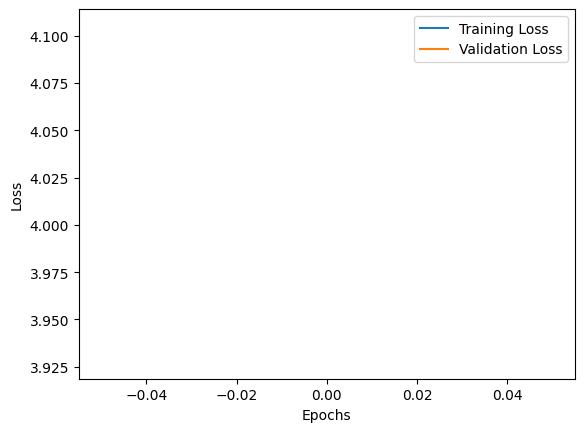

In [29]:
train(bigram)

Epoch 1/1: 100%|██████████| 872/872 [00:18<00:00, 48.32it/s]


Training Loss: 3.4278281279113316
Validation Loss: 2.812188126625271


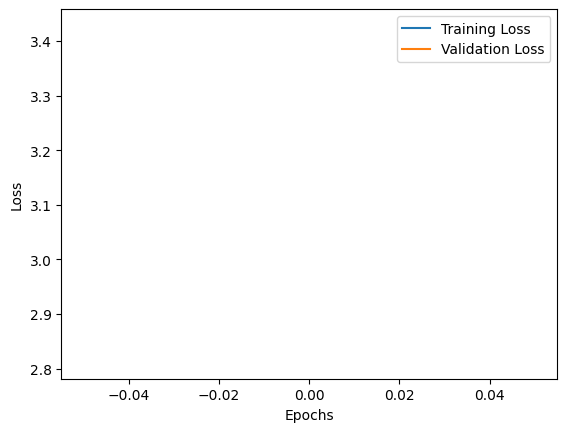

In [30]:
train(transformer)

# Inference

In [33]:
bigram.generate(sample_x, decode_fn=decode)

 wpbBu.
Ae wpbBu.
Ae wpbBu.
Ae wpbBu.
Ae wpbBu.
Ae wpbBu.
Ae wpbBu.
Ae wpbBu.
Ae wpbBu.
Ae wpbBu.
Ae

In [34]:
transformer.generate(sample_x, decode_fn=decode)

 the the the the the the the the the the the the the the the the the the the the the the the